In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import ResNet50
from keras import regularizers

import keras.backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

from IPython.display import HTML

In [4]:
train_dir = "Dataset/train/" #passing the path with training images
test_dir = "Dataset/test/"   #passing the path with testing images

In [5]:
def jumlah(path, set_):
    dict_ = {}
    for tingkatan in os.listdir(path):
        dir_ = path + tingkatan
        dict_[tingkatan] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

print(jumlah(train_dir, 'train'))
print(jumlah(test_dir, 'test'))

       angry  disgust  fear  happy  neutral   sad
train   3995      436  4097   7215     4965  4830
      angry  disgust  fear  happy  neutral   sad
test    958      111  1024   1774     1233  1247


In [6]:
img_size = 48 #original size of the image

"""
Augmentasi Data
--------------------------
rotasi_range = memutar gambar dengan besaran derajat yang kita sediakan
width_shift_range = menggeser gambar secara acak ke kanan atau ke kiri sepanjang lebar gambar
height_shift range = menggeser gambar secara acak ke atas atau ke bawah sepanjang tinggi gambar
horizontal_flip = membalik gambar secara horizontal
rescale = untuk memperkecil nilai pizel pada gambar kita antara 0 dan 1
zoom_range = menerapkan zoom acak pada objek kita
validation_split = mencadangkan beberapa gambar untuk digunakan untuk tujuan validasi
"""

In [7]:
#train_datagen/validation_datagen = variable
#ImageDataGenerator = fungsi

train_datagen = ImageDataGenerator(     width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         zoom_range = 0.2,
                                         featurewise_center = False,
                                         rotation_range = 10
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,)

In [8]:
"""
Applying data augmentation to the images as we read 
them from their respectivve directories
"""
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    class_mode = "categorical",
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              shuffle = True, 
                                                              class_mode = "categorical",
                                                              
                                                             )

Found 25538 images belonging to 6 classes.
Found 6347 images belonging to 6 classes.


In [9]:
class_labels = validation_generator.class_indices
class_labels

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}

In [10]:
#Melihat shape
train_sample = next(train_generator)
print(train_sample[0].shape)

(64, 48, 48, 3)


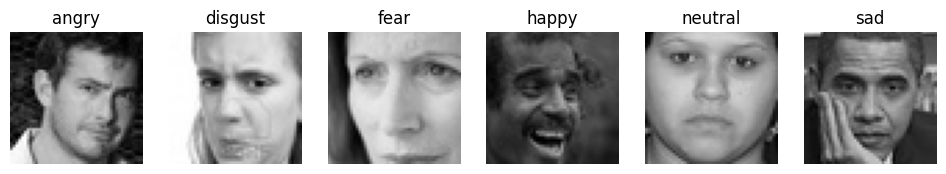

In [12]:
# Plot image of each class

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = image.load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [13]:
# Resnet50

base_model = tf.keras.applications.ResNet50(input_shape= (48,48,3),include_top=False,weights="imagenet")
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [14]:
for layer in base_model.layers:
    layer.trainable = True

model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dense(6, activation='softmax'))


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (Batch  (None, 8192)              32768     
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 6)                 49158     
                                                        

In [16]:
# Compile model

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

In [17]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 10,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=20)

In [18]:
gpus = tf.config.experimental.list_physical_devices('CPU')
print(gpus)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [20]:
history = model.fit(train_generator,validation_data = validation_generator, epochs=20, verbose=1, callbacks=[lrd,mcp,es])

Epoch 1/20
400/400 [==============================] - ETA: 0s - loss: 1.9329 - accuracy: 0.8120 - precision: 0.3625 - recall: 0.1692 - auc: 0.6681 - f1_score: 0.2295

c:\Users\Syarif Hidayat\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


400/400 [==============================] - 651s 2s/step - loss: 1.9329 - accuracy: 0.8120 - precision: 0.3625 - recall: 0.1692 - auc: 0.6681 - f1_score: 0.2295 - val_loss: 144.1295 - val_accuracy: 0.7165 - val_precision: 0.1495 - val_recall: 0.1495 - val_auc: 0.4913 - val_f1_score: 0.1498 - lr: 1.0000e-04
Epoch 2/20
400/400 [==============================] - 586s 1s/step - loss: 1.6537 - accuracy: 0.8356 - precision: 0.5187 - recall: 0.1881 - auc: 0.7316 - f1_score: 0.2758 - val_loss: 3.2834 - val_accuracy: 0.8125 - val_precision: 0.3017 - val_recall: 0.0953 - val_auc: 0.6304 - val_f1_score: 0.1434 - lr: 1.0000e-04
Epoch 3/20
400/400 [==============================] - 589s 1s/step - loss: 1.5124 - accuracy: 0.8456 - precision: 0.6053 - recall: 0.2107 - auc: 0.7676 - f1_score: 0.3104 - val_loss: 2.0824 - val_accuracy: 0.8435 - val_precision: 0.5628 - val_recall: 0.2724 - val_auc: 0.7657 - val_f1_score: 0.3666 - lr: 1.0000e-04
Epoch 4/20
400/400 [==============================] - 595s 1s

In [81]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_generator)
test_evaluation = model.evaluate(validation_generator)

100/100 [==============================] - 18s 179ms/step - loss: 1.0534 - accuracy: 0.8798 - precision: 0.7118 - recall: 0.4686 - auc: 0.8891 - f1_score: 0.5652


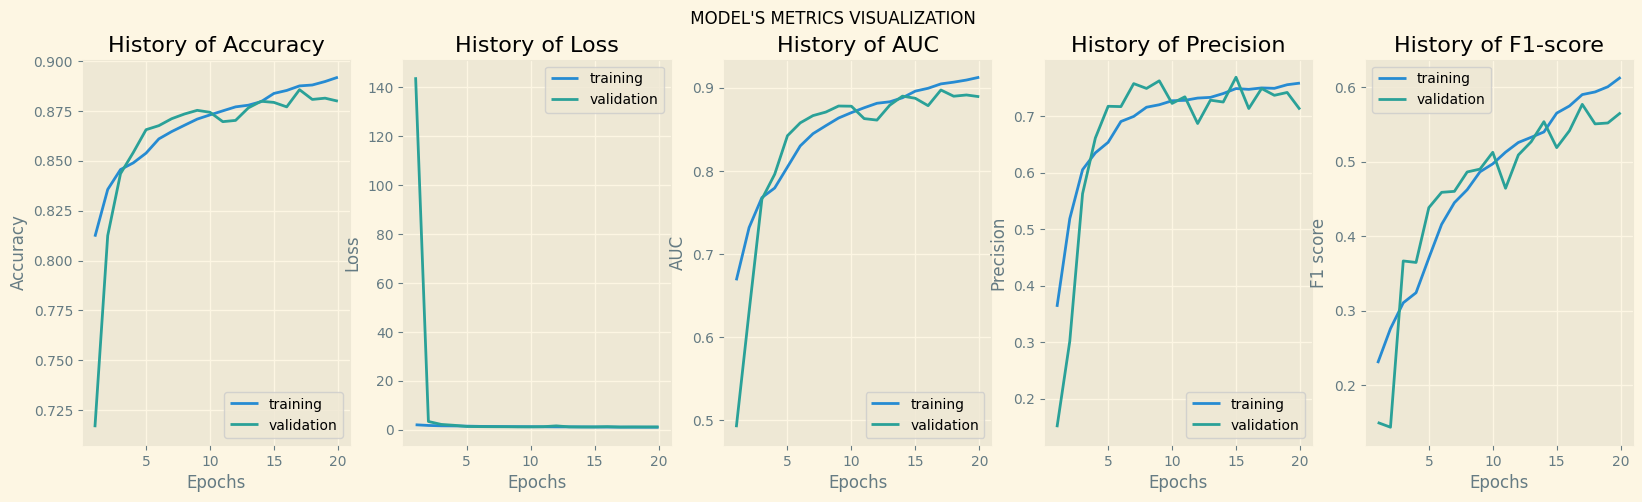

In [82]:
hs=history.history

acc = hs['accuracy']
val_acc = hs['val_accuracy']
loss =  hs['loss']
val_loss = hs['val_loss']
auc =  hs['auc']
val_auc = hs['val_auc']
precision =hs['precision']
val_precision =hs['val_precision']
f1 = hs['f1_score']
val_f1 = hs['val_f1_score']              

plt.style.use('Solarize_Light2')

fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training', 'validation'])

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

ax5.plot(range(1, len(f1) + 1), f1)
ax5.plot(range(1, len(val_f1) + 1), val_f1)
ax5.set_title('History of F1-score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 score')
ax5.legend(['training', 'validation'])

plt.show()

In [83]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_weight.h5")
print("Saved model to disk")

Saved model to disk


In [36]:
del result
del img_path
del test_image
del img
del y_pred

(48, 48, 1)


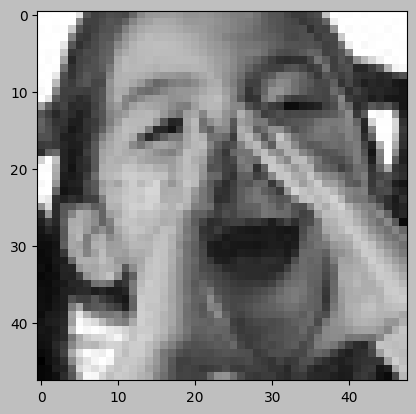

In [84]:
plt.style.use('grayscale')
plt.grid(visible=None)
img_path='Dataset/train/angry/Training_63181.jpg'
test_image=image.load_img(img_path,target_size= (48,48),color_mode='grayscale')
test_image=image.img_to_array(test_image)
print(test_image.shape)
plt.imshow(test_image)
plt.show()

In [85]:
img=image.load_img('Dataset/train/angry/Training_63181.jpg',target_size=(48,48))
img = np.expand_dims(img, axis=0)
print(img.shape)

(1, 48, 48, 3)


In [86]:
classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']


result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print('The person facial emotion is:',classes[y_pred])

1/1 [==============================] - 0s 51ms/step
[0. 0. 0. 0. 1. 0.]
The person facial emotion is: Neutral


In [39]:
model.save('modelku.h5')

c:\Users\Syarif Hidayat\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
